In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erf
from tqdm import tqdm

In [23]:
def reading_csv(file_path):
    df = pd.read_csv(file_path)
    mean_used = df['S2_val'].tolist()
    result    = df['Decision (S1>S2)'].tolist()
    data_tuple = (result, mean_used)
    return data_tuple

def data_var2(file_path):
    df = pd.read_csv(file_path)
    var2 = df['S2_std'].to_numpy()
    var2 = pd.unique(var2)     # valeurs uniques de S2_std
    return list(var2)

def psycometrique(data_tuple, var2, block_size=1500, big_blocs=11):
    """
    Reconstruit les moyennes par bloc comme dans ton code :
    - true_array_result[j][k] = P(1) pour le j-ième var2, k-ième S2_val
    - true_array_mean_used[j][k] = S2_val moyenne correspondante
    """
    result, mean_used = data_tuple
    true_array_mean_used = []
    true_array_result    = []

    size_one_block = block_size * big_blocs  # nb essais par courbe (11 x 200)

    for j in range(len(var2)):
        array_mean_result = []
        array_mean_used   = []
        for i in range(0, size_one_block, block_size):
            # bloc de result
            block_r = result[size_one_block*j + i : size_one_block*j + i + block_size]
            mean_r  = sum(block_r) / len(block_r)
            array_mean_result.append(mean_r)

            # bloc de mean_used
            block_m = mean_used[size_one_block*j + i : size_one_block*j + i + block_size]
            mean_m  = sum(block_m) / len(block_m)
            array_mean_used.append(mean_m)

        true_array_result.append(array_mean_result)
        true_array_mean_used.append(array_mean_used)

    return true_array_result, true_array_mean_used

def build_targets_from_csv(file_path, block_size=1500, big_blocs=11):
    """
    Construit :
      - target[(mu2, std2)] = P_empirique(réponse=1)
      - mus_test : liste ordonnée des S2_val utilisés
      - vars_test : liste ordonnée des S2_std utilisés
    à partir de ton CSV.
    """
    data_tuple = reading_csv(file_path)
    var2_list  = data_var2(file_path)           # S2_std uniques
    array_mean_result, array_mean_used = psycometrique(
        data_tuple, var2_list,
        block_size=block_size,
        big_blocs=big_blocs
    )

    target = {}
    # on suppose que les S2_val sont les mêmes pour chaque var2
    mus_test = array_mean_used[0]
    vars_test = var2_list

    for j, std2 in enumerate(var2_list):
        for k, mu2 in enumerate(array_mean_used[j]):
            p_emp = array_mean_result[j][k]
            target[(mu2, std2)] = p_emp

    return target, mus_test, vars_test

In [24]:
target, mus_test, vars_test = build_targets_from_csv('C:\\Users\\gabri\\Desktop\\bayesian\\experiment_results_1500.csv') # before experiment_results_test.csv 
print(target)

{(-10.0, np.int64(0)): 1.0, (-8.0, np.int64(0)): 1.0, (-6.0, np.int64(0)): 1.0, (-4.0, np.int64(0)): 1.0, (-2.0, np.int64(0)): 0.9993333333333333, (0.0, np.int64(0)): 0.4746666666666667, (2.0, np.int64(0)): 0.005333333333333333, (4.0, np.int64(0)): 0.0, (6.0, np.int64(0)): 0.0, (8.0, np.int64(0)): 0.0, (10.0, np.int64(0)): 0.0, (-10.0, np.int64(2)): 1.0, (-8.0, np.int64(2)): 0.9986666666666667, (-6.0, np.int64(2)): 0.9953333333333333, (-4.0, np.int64(2)): 0.9566666666666667, (-2.0, np.int64(2)): 0.8313333333333334, (0.0, np.int64(2)): 0.5873333333333334, (2.0, np.int64(2)): 0.346, (4.0, np.int64(2)): 0.11333333333333333, (6.0, np.int64(2)): 0.04133333333333333, (8.0, np.int64(2)): 0.008, (10.0, np.int64(2)): 0.0, (-10.0, np.int64(4)): 0.9526666666666667, (-8.0, np.int64(4)): 0.9266666666666666, (-6.0, np.int64(4)): 0.8886666666666667, (-4.0, np.int64(4)): 0.8313333333333334, (-2.0, np.int64(4)): 0.73, (0.0, np.int64(4)): 0.642, (2.0, np.int64(4)): 0.536, (4.0, np.int64(4)): 0.454, (6.0

In [25]:
mus_test  = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
vars_test = [0,2,4,6,8]

def sample_dobs(mu1, std1, mu2, std2):
    A = np.random.normal(mu1, std1)
    B = np.random.normal(mu2, std2)
    return A - B

def posterior_params(dobs, std1, std2, mu0, std0):
    var_lik = std1**2 + std2**2      # v
    var0    = std0**2               # sigma0^2

    sigma_post2 = 1.0 / (1.0/var0 + 1.0/var_lik)
    mu_post     = sigma_post2 * (mu0/var0 + dobs/var_lik)
    return mu_post, np.sqrt(sigma_post2)

def Phi(z):
    # CDF normale standard avec scipy.special.erf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def prob_response_1(mu1, std1, mu2, std2, mu0, std0):
    """
    Tire un dobs, calcule le posterior, renvoie P(répondre 1) = P(x>0|dobs).
    """
    dobs = sample_dobs(mu1, std1, mu2, std2)
    mu_post, sigma_post = posterior_params(dobs, std1, std2, mu0, std0)
    return Phi(mu_post / sigma_post)

def agent_response(mu1, std1, mu2, std2, mu0, std0):
    """
    Agent stochastique : tire une Bernoulli avec proba = P(répondre 1).
    """
    p1 = prob_response_1(mu1, std1, mu2, std2, mu0, std0)
    return 1 if np.random.rand() < p1 else 0

mu1  = 0.0
std1 = 0.2
relation = 0.179 # before 0.15

def simulate_for_std0(std0, n_trials=2000):
    """
    Fixe std0, déduit mu0 = relation * std0**2, 
    puis calcule P_modèle(1) pour chaque (mu2, std2).
    """
    var0 = std0**2
    mu0  = relation * var0
    results = {}
    for mu2 in mus_test:
        for std2 in vars_test:
            count = 0
            for _ in range(n_trials):
                count += agent_response(mu1, std1, mu2, std2, mu0, std0)
            results[(mu2, std2)] = count / n_trials
    return mu0, results

def mse_for_std0(std0, n_trials=2000):
    mu0, sim = simulate_for_std0(std0, n_trials=n_trials)
    err = 0.0
    for key, target_val in target.items():
        err += (sim[key] - target_val)**2
    return mu0, err / len(target), sim

# ========= 4) Grid search sur std0 (mu0 déduit du ratio) =========

std0_grid = np.linspace(2, 5.0, 100)   # à ajuster si besoin

best_std0 = None
best_mu0  = None
best_mse  = np.inf
best_sim  = None

mse_array = []
for std0 in std0_grid:
    mu0, mse, sim = mse_for_std0(std0, n_trials=1500)
    mse_array.append(mse)
    print(f"std0={std0:.2f}, mu0={mu0:.3f}, MSE={mse:.5f}")
    if mse < best_mse:
        best_mse = mse
        best_std0 = std0
        best_mu0  = mu0
        best_sim  = sim

print(f"\nBEST PARAMETERS (avec mu0/sigma0^2 = {relation} fixé) :")
print(f"std0={best_std0:.3f}, mu0={best_mu0:.3f}, MSE={best_mse:.6f}")

# ========= 5) Plot psychométriques : données vs meilleur agent =========

plt.figure(figsize=(8,5))
colors = {
    0: "tab:purple",
    2: "tab:blue",
    4: "tab:orange",
    6: "tab:green",
    8: "tab:red"
}


for std2 in vars_test:
    xs = mus_test
    ys_model  = [best_sim[(mu2, std2)]   for mu2 in mus_test]
    ys_target = [target[(mu2, std2)]     for mu2 in mus_test]

    plt.plot(xs, ys_model,  "-o", label=f"modèle var={std2}",  color=colors[std2])
    plt.plot(xs, ys_target, "--",  alpha=0.5, color=colors[std2])

plt.axhline(0.5, linestyle="--", color="red", alpha=0.5, label="Chance (0.5)")
plt.xlabel("Mean S2 value (mu2)")
plt.ylabel("P(réponse=1)")
plt.title(f"Psychometric functions : données vs agent bayésien\n(mu0/sigma0^2 = {relation} fixé)")
plt.legend()
plt.grid(True)
plt.show()


std0=2.00, mu0=0.716, MSE=0.00155
std0=2.03, mu0=0.738, MSE=0.00144
std0=2.06, mu0=0.760, MSE=0.00127
std0=2.09, mu0=0.783, MSE=0.00115
std0=2.12, mu0=0.805, MSE=0.00105
std0=2.15, mu0=0.829, MSE=0.00109
std0=2.18, mu0=0.852, MSE=0.00087
std0=2.21, mu0=0.876, MSE=0.00082


KeyboardInterrupt: 

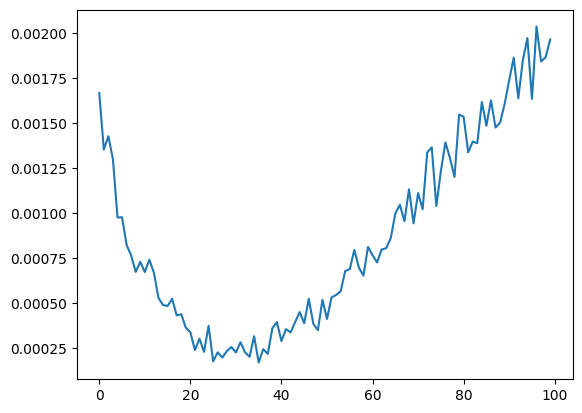

In [ ]:
plt.plot(mse_array)

get off the relation with numpy

Grid search sur (mu0, std0) ...


100%|██████████| 110/110 [02:49<00:00,  1.54s/it]



BEST PARAMETERS :
mu0=1.514, std0=2.921, MSE=0.000132


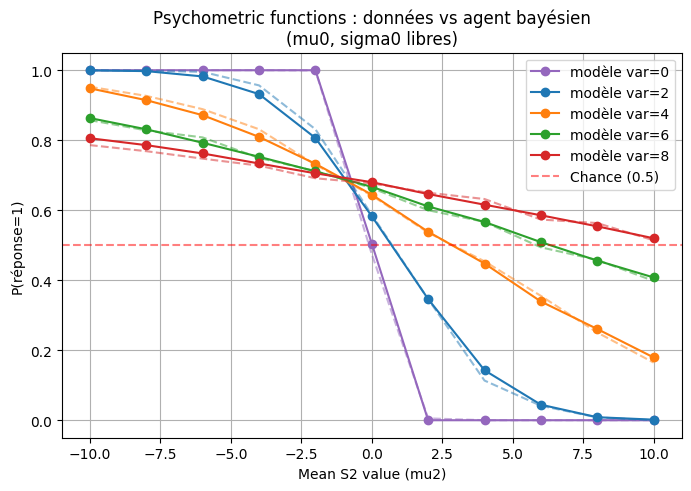

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

mus_test  = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
vars_test = [0,2,4,6,8]   # attention : il faut que ça colle aux std dans target

mu1  = 0.0
std1 = 0.2

def sample_dobs(mu1, std1, mu2, std2, n_trials):
    A = np.random.normal(mu1, std1, size=n_trials)
    B = np.random.normal(mu2, std2, size=n_trials)
    return A - B  # vecteur

def posterior_params(dobs, std1, std2, mu0, std0):
    var_lik = std1**2 + std2**2      # v
    var0    = std0**2               # sigma0^2

    sigma_post2 = 1.0 / (1.0/var0 + 1.0/var_lik)
    mu_post     = sigma_post2 * (mu0/var0 + dobs/var_lik)
    return mu_post, np.sqrt(sigma_post2)

def Phi(z):
    # CDF normale standard avec scipy.special.erf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def simulate_for_params(mu0, std0, n_trials=2000):
    """
    Calcule P_modèle(1) pour chaque (mu2, std2) via
    E[ Phi(mu_post / sigma_post) ].
    """
    results = {}
    for mu2 in mus_test:
        for std2 in vars_test:
            dobs = sample_dobs(mu1, std1, mu2, std2, n_trials)
            mu_post, sigma_post = posterior_params(dobs, std1, std2, mu0, std0)
            probs = Phi(mu_post / sigma_post)   # vecteur
            results[(mu2, std2)] = probs.mean() # P_modèle(1)
    return results

def mse_for_params(mu0, std0, target, n_trials=2000):
    sim = simulate_for_params(mu0, std0, n_trials=n_trials)
    err = 0.0
    for key, target_val in target.items():
        err += (sim[key] - target_val)**2
    return err / len(target), sim

from tqdm import tqdm

# ex : recherche sur [-5,5] pour mu0, [0.5,6] pour std0
mu0_grid  = np.linspace(-3, 3, 110)     # pas de 0.25
std0_grid = np.linspace(0.1, 5.0, 100)  # pas de ~0.19

best_mu0  = None
best_std0 = None
best_mse  = np.inf
best_sim  = None

print("Grid search sur (mu0, std0) ...")

for mu0 in tqdm(mu0_grid):
    for std0 in std0_grid:
        mse, sim = mse_for_params(mu0, std0, target, n_trials=2000)
        if mse < best_mse:
            best_mse  = mse
            best_mu0  = mu0
            best_std0 = std0
            best_sim  = sim

print("\nBEST PARAMETERS :")
print(f"mu0={best_mu0:.3f}, std0={best_std0:.3f}, MSE={best_mse:.6f}")

plt.figure(figsize=(8,5))
colors = {
    0: "tab:purple",
    2: "tab:blue",
    4: "tab:orange",
    6: "tab:green",
    8: "tab:red"
}

for std2 in vars_test:
    xs = mus_test
    ys_model  = [best_sim[(mu2, std2)]   for mu2 in mus_test]
    ys_target = [target[(mu2, std2)]     for mu2 in mus_test]

    plt.plot(xs, ys_model,  "-o", label=f"modèle var={std2}",  color=colors[std2])
    plt.plot(xs, ys_target, "--",  alpha=0.5, color=colors[std2])

plt.axhline(0.5, linestyle="--", color="red", alpha=0.5, label="Chance (0.5)")
plt.xlabel("Mean S2 value (mu2)")
plt.ylabel("P(réponse=1)")
plt.title("Psychometric functions : données vs agent bayésien\n(mu0, sigma0 libres)")
plt.legend()
plt.grid(True)
plt.show()


std0=0.10, mu0=0.002, MSE=0.05943
std0=0.64, mu0=0.062, MSE=0.03284
std0=1.19, mu0=0.212, MSE=0.02224
std0=1.73, mu0=0.451, MSE=0.01797
std0=2.28, mu0=0.778, MSE=0.01586
std0=2.82, mu0=1.195, MSE=0.01465
std0=3.37, mu0=1.700, MSE=0.01386
std0=3.91, mu0=2.295, MSE=0.01388
std0=4.46, mu0=2.978, MSE=0.01413
std0=5.00, mu0=3.750, MSE=0.01472

BEST PARAMETERS (avec mu0/sigma0^2 = 0.15 fixé) :
std0=3.367, mu0=1.700, MSE=0.013855


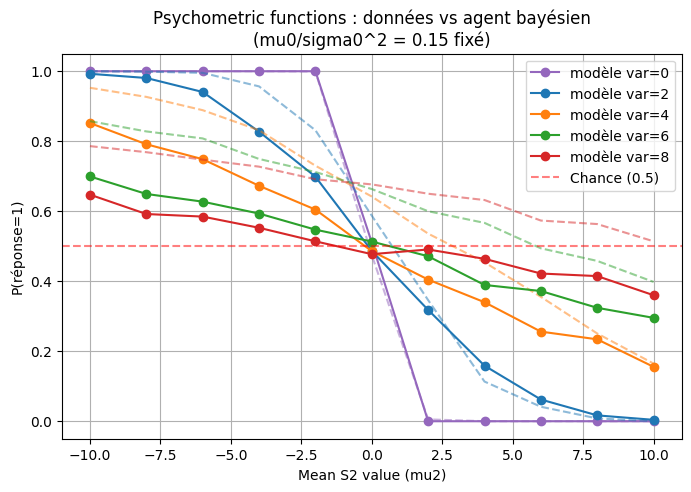

In [26]:
mus_test  = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
vars_test = [0,2,4,6,8]

def sample_dobs(mu1, std1, mu2, std2):
    A = np.random.normal(mu1, std1)
    B = np.random.normal(mu2, std2)
    return A, B

def posterior_params(dobs, std1, std2, mu0, std0):
    var_lik = std1**2 + std2**2      # v
    var0    = std0**2               # sigma0^2

    sigma_post2 = 1.0 / (1.0/var0 + 1.0/var_lik)
    mu_post     = sigma_post2 * (mu0/var0 + dobs/var_lik)
    return mu_post, np.sqrt(sigma_post2)

def Phi(z):
    # CDF normale standard avec scipy.special.erf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def prob_response_1(mu1, std1, mu2, std2, mu0, std0):
    """
    Tire un dobs, calcule le posterior, renvoie P(répondre 1) = P(x>0|dobs).
    """
    A, B = sample_dobs(mu1, std1, mu2, std2)
    mu_post_a, sigma_post_a = posterior_params(A, std1, std2, mu0, std0)
    mu_post_b, sigma_post_b = posterior_params(B, std1, std2, mu0, std0)
    return Phi((mu_post_a - mu_post_b) / (sigma_post_a**2 + sigma_post_b**2)**0.5)

def agent_response(mu1, std1, mu2, std2, mu0, std0):
    """
    Agent stochastique : tire une Bernoulli avec proba = P(répondre 1).
    """
    p1 = prob_response_1(mu1, std1, mu2, std2, mu0, std0)
    return 1 if np.random.rand() < p1 else 0

mu1  = 0.0
std1 = 0.2
relation = 0.15 # before 0.15

def simulate_for_std0(std0, n_trials=2000):
    """
    Fixe std0, déduit mu0 = relation * std0**2, 
    puis calcule P_modèle(1) pour chaque (mu2, std2).
    """
    var0 = std0**2
    mu0  = relation * var0
    results = {}
    for mu2 in mus_test:
        for std2 in vars_test:
            count = 0
            for _ in range(n_trials):
                count += agent_response(mu1, std1, mu2, std2, mu0, std0)
            results[(mu2, std2)] = count / n_trials
    return mu0, results

def mse_for_std0(std0, n_trials=2000):
    mu0, sim = simulate_for_std0(std0, n_trials=n_trials)
    err = 0.0
    for key, target_val in target.items():
        err += (sim[key] - target_val)**2
    return mu0, err / len(target), sim

# ========= 4) Grid search sur std0 (mu0 déduit du ratio) =========

std0_grid = np.linspace(0.1, 5.0, 10)   # à ajuster si besoin

best_std0 = None
best_mu0  = None
best_mse  = np.inf
best_sim  = None

mse_array = []
for std0 in std0_grid:
    mu0, mse, sim = mse_for_std0(std0, n_trials=1500)
    mse_array.append(mse)
    print(f"std0={std0:.2f}, mu0={mu0:.3f}, MSE={mse:.5f}")
    if mse < best_mse:
        best_mse = mse
        best_std0 = std0
        best_mu0  = mu0
        best_sim  = sim

print(f"\nBEST PARAMETERS (avec mu0/sigma0^2 = {relation} fixé) :")
print(f"std0={best_std0:.3f}, mu0={best_mu0:.3f}, MSE={best_mse:.6f}")

# ========= 5) Plot psychométriques : données vs meilleur agent =========

plt.figure(figsize=(8,5))
colors = {
    0: "tab:purple",
    2: "tab:blue",
    4: "tab:orange",
    6: "tab:green",
    8: "tab:red"
}


for std2 in vars_test:
    xs = mus_test
    ys_model  = [best_sim[(mu2, std2)]   for mu2 in mus_test]
    ys_target = [target[(mu2, std2)]     for mu2 in mus_test]

    plt.plot(xs, ys_model,  "-o", label=f"modèle var={std2}",  color=colors[std2])
    plt.plot(xs, ys_target, "--",  alpha=0.5, color=colors[std2])

plt.axhline(0.5, linestyle="--", color="red", alpha=0.5, label="Chance (0.5)")
plt.xlabel("Mean S2 value (mu2)")
plt.ylabel("P(réponse=1)")
plt.title(f"Psychometric functions : données vs agent bayésien\n(mu0/sigma0^2 = {relation} fixé)")
plt.legend()
plt.grid(True)
plt.show()


Grid search sur (mu0, std0) ...


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]



BEST PARAMETERS :
mu0=0.333, std0=4.456, MSE=0.012803


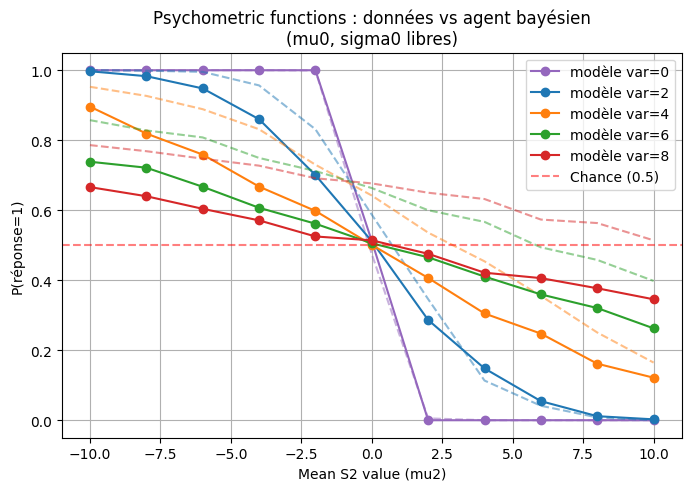

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

mus_test  = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
vars_test = [0,2,4,6,8]   # attention : il faut que ça colle aux std dans target

mu1  = 0.0
std1 = 0.2

def sample_dobs(mu1, std1, mu2, std2, n_trials):
    A = np.random.normal(mu1, std1, size=n_trials)
    B = np.random.normal(mu2, std2, size=n_trials)
    return A, B  # vecteur

def posterior_params(dobs, std1, std2, mu0, std0):
    var_lik = std1**2 + std2**2      # v
    var0    = std0**2               # sigma0^2

    sigma_post2 = 1.0 / (1.0/var0 + 1.0/var_lik)
    mu_post     = sigma_post2 * (mu0/var0 + dobs/var_lik)
    return mu_post, np.sqrt(sigma_post2)

def Phi(z):
    # CDF normale standard avec scipy.special.erf
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

def simulate_for_params(mu0, std0, n_trials=2000):
    """
    Calcule P_modèle(1) pour chaque (mu2, std2) via
    E[ Phi(mu_post / sigma_post) ].
    """
    results = {}
    for mu2 in mus_test:
        for std2 in vars_test:
            A, B = sample_dobs(mu1, std1, mu2, std2, n_trials)
            mu_post_a, sigma_post_a = posterior_params(A, std1, std2, mu0, std0)
            mu_post_b, sigma_post_b = posterior_params(B, std1, std2, mu0, std0)
            probs = Phi((mu_post_a - mu_post_b) / (sigma_post_a**2 + sigma_post_b**2)**0.5)   # vecteur
            results[(mu2, std2)] = probs.mean() # P_modèle(1)
    return results

def mse_for_params(mu0, std0, target, n_trials=2000):
    sim = simulate_for_params(mu0, std0, n_trials=n_trials)
    err = 0.0
    for key, target_val in target.items():
        err += (sim[key] - target_val)**2
    return err / len(target), sim

from tqdm import tqdm

# ex : recherche sur [-5,5] pour mu0, [0.5,6] pour std0
mu0_grid  = np.linspace(-3, 3, 110)     # pas de 0.25
std0_grid = np.linspace(0.1, 5.0, 100)  # pas de ~0.19

best_mu0  = None
best_std0 = None
best_mse  = np.inf
best_sim  = None

print("Grid search sur (mu0, std0) ...")

for mu0 in tqdm(mu0_grid):
    for std0 in std0_grid:
        mse, sim = mse_for_params(mu0, std0, target, n_trials=2000)
        if mse < best_mse:
            best_mse  = mse
            best_mu0  = mu0
            best_std0 = std0
            best_sim  = sim

print("\nBEST PARAMETERS :")
print(f"mu0={best_mu0:.3f}, std0={best_std0:.3f}, MSE={best_mse:.6f}")

plt.figure(figsize=(8,5))
colors = {
    0: "tab:purple",
    2: "tab:blue",
    4: "tab:orange",
    6: "tab:green",
    8: "tab:red"
}

for std2 in vars_test:
    xs = mus_test
    ys_model  = [best_sim[(mu2, std2)]   for mu2 in mus_test]
    ys_target = [target[(mu2, std2)]     for mu2 in mus_test]

    plt.plot(xs, ys_model,  "-o", label=f"modèle var={std2}",  color=colors[std2])
    plt.plot(xs, ys_target, "--",  alpha=0.5, color=colors[std2])

plt.axhline(0.5, linestyle="--", color="red", alpha=0.5, label="Chance (0.5)")
plt.xlabel("Mean S2 value (mu2)")
plt.ylabel("P(réponse=1)")
plt.title("Psychometric functions : données vs agent bayésien\n(mu0, sigma0 libres)")
plt.legend()
plt.grid(True)
plt.show()
